### LightGBM e LSTM para classificação de textos

Vamos aplicar o LightGBM e uma rede LSTM para classificação de textos do dataset de avaliações de roupas femininas da Kaggle [Women’s E-Commerce Clothing Reviews Dataset](https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews)

A base possui as seguintes informações:

* Clothing ID: ID da revisão.
* Age: Idade da cliente.
* Title: Título da revisão.
* Review Text: Texto da revisão.
* Rating: Variável inteira ordinal para a pontuação do produto concedida pelo cliente variando de 1 (pior) a 5 (melhor).
* Recommended IND: Variável binária informando se o cliente recomenda o produto, na qual 1 é recomendado, 0 não é recomendado.
* Positive Feedback Count: Número de outros clientes que acharam esta avaliação positiva.
* Division Name: Divisão do produto.
* Department Name: Departamento do produto.
* Class Name: Classe do produto.


O objetivo é utilizar o texto da revisão (Review Text) para prever a recomendação ou não do produto (Recommended IND). Vou utilizar duas técnicas: LightGBM e LSTM. 

No primeiro momento vamos conhecer um pouco da base, em seguida construir e comparar os classificadores.

---

Essa aplicação foi inspirada no seguinte post: 
[EDA & LSTM Classification on clothing reviews](https://www.kaggle.com/code/wonduk/eda-lstm-classification-on-clothing-reviews)

---

In [1]:
import nltk
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("bases\\kaggle-clothing_reviews\\Womens Clothing E-Commerce Reviews.csv", index_col=0)

In [3]:
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


Como só nos interessa as avaliações com revisões por isso vamos excluir as ausentes:

In [4]:
df[df['Review Text'].isnull()]

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
92,861,23,NaN,NaN,5,1,0,General Petite,Tops,Knits
93,1081,31,NaN,NaN,5,1,0,General,Dresses,Dresses
98,1133,50,NaN,NaN,5,1,0,General,Jackets,Outerwear
135,861,35,NaN,NaN,4,1,0,General Petite,Tops,Knits
142,1126,35,NaN,NaN,5,1,0,General,Jackets,Outerwear
...,...,...,...,...,...,...,...,...,...,...
23258,862,35,NaN,NaN,4,1,0,General,Tops,Knits
23301,862,52,NaN,NaN,5,1,0,General,Tops,Knits
23303,823,46,NaN,NaN,5,1,0,General,Tops,Blouses
23470,1104,39,NaN,NaN,5,1,0,General Petite,Dresses,Dresses


In [5]:
df.dropna(inplace=True)

### Distribuição dos valores no Rating & Recommended IND

In [6]:
import matplotlib.pyplot as plt

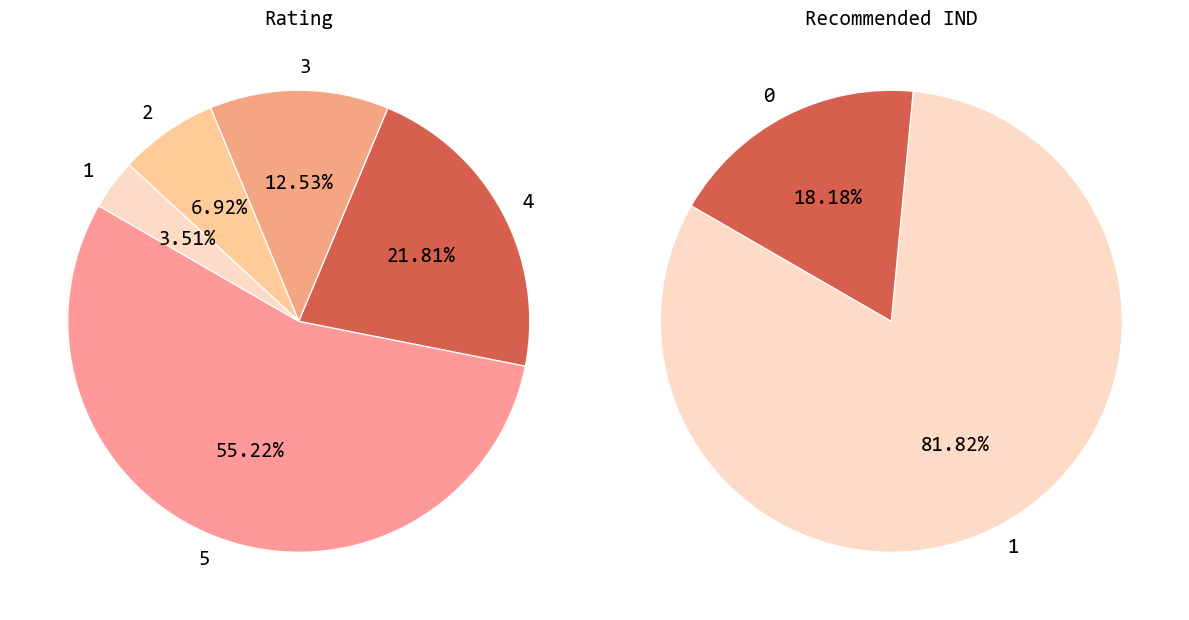

In [7]:
rating = df['Rating'].value_counts()
recommended = df['Recommended IND'].value_counts().sort_values(ascending=False)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,7))

csfont = {'fontname':"Consolas", 'fontsize': 15}
ax1.pie(rating.values, labels=rating.index, 
        autopct='%1.2f%%', startangle=150, 
        colors=['#ff9999','#d6604d','#f4a582','#ffcc99', '#fddbc7'], 
        wedgeprops = { 'linewidth' : 0.9, 'edgecolor' : 'white' }, textprops=csfont)

ax2.pie(recommended.values, labels=recommended.index, 
        autopct='%1.2f%%', startangle=150, colors=['#fddbc7','#d6604d'], 
        wedgeprops = { 'linewidth' : 0.9, 'edgecolor' : 'white' }, textprops=csfont)

ax1.set_title('Rating', **csfont)
ax2.set_title('Recommended IND', **csfont)

plt.tight_layout()
plt.show()

### Processamento dos textos

A seguir a lista de funções utilizadas para fazer ajustes no texto como remoção de stopwords e lemmatization

In [8]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [9]:
stoplist = stopwords.words('english')

# Junta todos os textos em uma única string
def get_all_str(sentences):
    sentence = ''
    for words in sentences:
        sentence += words
    sentence = sentence.lower()
    return sentence

# Quebra o texto em uma sequência de palavras (tokens)
def get_words(text): 
    return nltk.RegexpTokenizer(r'\w+').tokenize(text.lower())

# Remove as stopwords de uma lista de palavras
def remove_stopword(words):        
    return [word for word in words if word not in stoplist] 

# Aplica o processo de lemmatize
def lemmatization(words):
    lemm = WordNetLemmatizer()
    return [lemm.lemmatize(word) for word in words]

# Frequencia das palavras de um texto
def Freq_df(cleanwordlist):
    Freq_dist_nltk = nltk.FreqDist(cleanwordlist)
    df_freq = pd.DataFrame.from_dict(Freq_dist_nltk, orient='index')
    df_freq.columns = ['Frequency']
    df_freq.index.name = 'Term'
    df_freq = df_freq.sort_values(by=['Frequency'],ascending=False)
    return df_freq.reset_index()

# Consolidação das funções
def preprocess(text, freq=False):
    words = get_words(text)
    after_removing = remove_stopword(words)
    lemmatize = lemmatization(after_removing)
    if freq:
        return Freq_df(lemmatize)
    return lemmatize

Exemplo em uma avaliação:

In [10]:
text = df['Review Text'].iloc[6]
text

'I love this dress. i usually get an xs but it runs a little snug in bust so i ordered up a size. very flattering and feminine with the usual retailer flair for style.'

In [11]:
print(preprocess(text, freq=False))

['love', 'dress', 'usually', 'get', 'x', 'run', 'little', 'snug', 'bust', 'ordered', 'size', 'flattering', 'feminine', 'usual', 'retailer', 'flair', 'style']


In [12]:
print(preprocess(text, freq=True))

          Term  Frequency
0         love          1
1      ordered          1
2        flair          1
3     retailer          1
4        usual          1
5     feminine          1
6   flattering          1
7         size          1
8         bust          1
9        dress          1
10        snug          1
11      little          1
12         run          1
13           x          1
14         get          1
15     usually          1
16       style          1


As 10 palavras mais frequentes da base:

In [13]:
import plotly.express as px

In [14]:
top10_frequent = preprocess(get_all_str(df['Review Text']), freq=True)[:10]

In [15]:
import plotly.express as px

In [16]:
px.colors.sequential.RdBu

['rgb(103,0,31)',
 'rgb(178,24,43)',
 'rgb(214,96,77)',
 'rgb(244,165,130)',
 'rgb(253,219,199)',
 'rgb(247,247,247)',
 'rgb(209,229,240)',
 'rgb(146,197,222)',
 'rgb(67,147,195)',
 'rgb(33,102,172)',
 'rgb(5,48,97)']

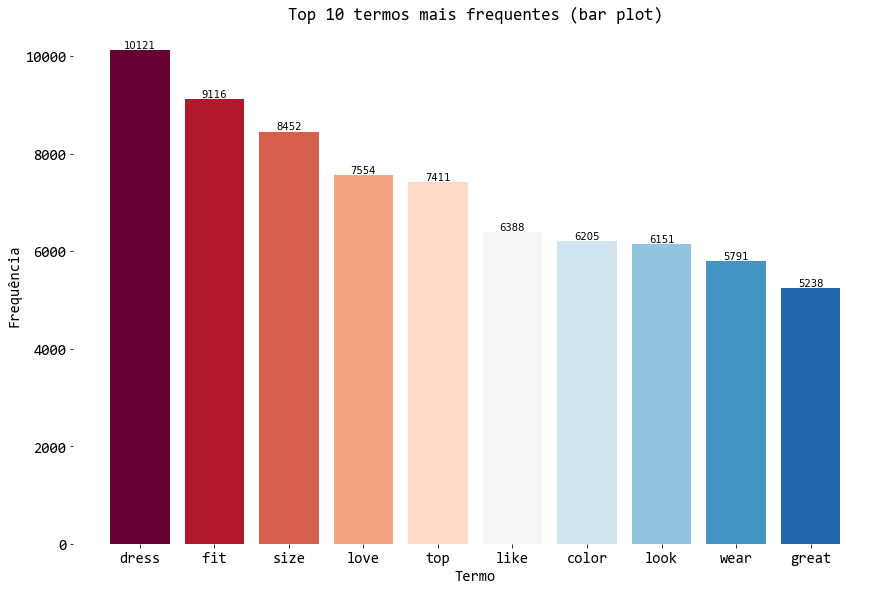

In [17]:
fig, ax = plt.subplots(figsize=(12,8))
plt.bar(top10_frequent.Term, top10_frequent.Frequency, 
        color=['#660033', '#B2182B', '#D6604D', '#F4A582', '#FDDBC7', '#F7F7F7', '#D1E5F0', '#92C5DE', '#4393C3', '#2166AC'])
plt.title('Top 10 termos mais frequentes (bar plot)', {'fontname':"Consolas", 'fontsize': 17})
plt.tight_layout()
plt.xlabel("Termo", **csfont)
plt.ylabel("Frequência", **csfont)
plt.yticks(**csfont)
plt.xticks(**csfont)
ax.set(frame_on=False)
for i in range(len(top10_frequent.Term)):
    plt.annotate(str(top10_frequent.Frequency[i]), 
                 xy=(top10_frequent.Term[i],top10_frequent.Frequency[i]), ha='center', va='bottom')

plt.show()

Aplicando o processo em todos os textos da base de avaliações

In [18]:
df['Text'] = df['Review Text'].apply(preprocess)

## Modelagem

### Train-Test Split

Vamos separar 30% da base para a fase de teste

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
y = df['Recommended IND']
X = df.drop('Recommended IND',axis=1)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X['Text'], y, test_size=0.3, random_state = 42)    

### LightGBM

Antes de construir nosso classificador precisamos transformar os textos em uma matriz numerica. Neste exemplo, vou usar o TF_IDF.

#### Tokenization, Matriz TF-IDF


In [22]:
import lightgbm as lgb
from sklearn.feature_extraction.text import TfidfVectorizer

In [23]:
vectorizer = TfidfVectorizer(min_df=200, use_idf=True, smooth_idf=True)

In [24]:
X_train_tfidf = vectorizer.fit_transform(X_train.apply(" ".join))
X_test_tfidf = vectorizer.transform(X_test.apply(" ".join))

In [25]:
x_train = lgb.Dataset(X_train_tfidf,y_train)
x_test = lgb.Dataset(X_test_tfidf,y_test)

In [26]:
param_lgb = {
    'max_depth': 20,
    'learning_rate': 0.33,
    'max_bin': 1000,
    'num_leaves' : 50,
    'objective': 'binary',
    'metric': 'auc',
    'num_iter': 1000
}

In [27]:
lgm_model = lgb.train(param_lgb, x_train, valid_sets=x_test)

[LightGBM] [Warning] Unknown parameter: num_iter
[LightGBM] [Warning] Unknown parameter: num_iter
[LightGBM] [Info] Number of positive: 11297, number of negative: 2466
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015929 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 82058
[LightGBM] [Info] Number of data points in the train set: 13763, number of used features: 363
[LightGBM] [Warning] Unknown parameter: num_iter
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.820824 -> initscore=1.521940
[LightGBM] [Info] Start training from score 1.521940
[1]	valid_0's auc: 0.802179
[2]	valid_0's auc: 0.839115
[3]	valid_0's auc: 0.848228
[4]	valid_0's auc: 0.854728
[5]	valid_0's auc: 0.864925
[6]	valid_0's auc: 0.869022
[7]	valid_0's auc: 0.872138
[8]	valid_0's auc: 0.874786
[9]	valid_0's auc: 0.876956
[10]	valid_0's auc: 0.877747
[11]	valid_0

### LSTM

#### Tokenization, Sequencing e Padding

In [28]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

Primeiro, obtemos o comprimento máximo do texto que será usado no padding

In [29]:
max_len = max(max(X_train.apply(len).values),max(X_test.apply(len).values))

In [30]:
# Tokenization
def fit_tokenizer(text, oov_token):
    tokenizer = Tokenizer(oov_token = oov_token)
    tokenizer.fit_on_texts(text)
    return tokenizer

# Padding
def seq_padding(sentences, tokenizer, padding, truncating, maxlen):
    sequences = tokenizer.texts_to_sequences(sentences)    
    pad_trunc_sequences = pad_sequences(sequences, padding = padding, maxlen = maxlen, truncating=padding)
    return pad_trunc_sequences

Novos X_train and X_test após sequenciamento e preenchimento (padding)

In [31]:
tokenizer = fit_tokenizer(X_train, "<OOV>")

word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index)

train_X = seq_padding(X_train,tokenizer, 'post', 'post',max_len)
test_X = seq_padding(X_test,tokenizer, 'post', 'post', max_len)

In [32]:
train_X

array([[  20,   83,    2, ...,    0,    0,    0],
       [  33,    2,   31, ...,    0,    0,    0],
       [ 182,  419,    8, ...,    0,    0,    0],
       ...,
       [  16,  165,    4, ...,    0,    0,    0],
       [   6, 1552,  567, ...,    0,    0,    0],
       [   6,  660,  252, ...,    0,    0,    0]])

#### GloVe Embedding

GloVe é um algoritmo de aprendizado não supervisionado para obter representações vetoriais das palavras. Vamos usá-lo para obter os vetores de cada palavra

In [33]:
GLOVE_FILE = 'glove.6B.100d\\glove.6B.100d.txt'
GLOVE_EMBEDDINGS = {}

with open(GLOVE_FILE, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        GLOVE_EMBEDDINGS[word] = coefs

Existe alguma palavra que o GloVe não contempla?

In [34]:
EMBEDDINGS_MATRIX = np.zeros((VOCAB_SIZE+1, 100))

num = 0
missed_list = []

for word, i in word_index.items():
    embedding_vector = GLOVE_EMBEDDINGS.get(word)
    if embedding_vector is not None:
        EMBEDDINGS_MATRIX[i] = embedding_vector
    else:
        num += 1
        missed_list.append(word)

print('Quantas palavras fora do GloVe? ',num)
print('Por exemplo: ',missed_list[:10])

Quantas palavras fora do GloVe?  1463
Por exemplo:  ['<OOV>', 'pilcro', 'armhole', '34d', 'xsp', '0p', '36d', 'xxsp', '34dd', '32dd']


#### Modelo LSTM

Conforme proposto no artigo original, vamos seguir com a mesma arquitetura que contém uma LSTM Bidirecional, dropout e regularizadores (L2) para evitar o overfitting.

* **Embedding**: A camada Embedding pode ser entendida como uma tabela de pesquisa que mapeia desde índices inteiros (que representam palavras específicas) até vetores densos (seus embeddings). 
* **Dropout**: A camada Dropout trabalha escolhendo aleatoriamente unidades a serem desativadas na rede. Esse processo ajuda a evitar o overfitting.

In [35]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, GlobalMaxPool1D, Dropout

# Definição do modelo
def LSTM_model(vocab_size, embedding_dim, maxlen, embeddings_matrix):
    
    model = Sequential()
    
    model.add(Embedding(vocab_size+1,embedding_dim,input_length = maxlen, weights = [embeddings_matrix],trainable=False))
    model.add(Bidirectional(LSTM(64,kernel_regularizer=keras.regularizers.l2(0.001))))
    model.add(Dropout(0.3))
    
    tf.keras.layers.GlobalAveragePooling1D()

    model.add(Dense(6, activation = 'relu', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation = 'sigmoid'))
    
    model.compile(loss = 'binary_crossentropy',
                  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                  metrics = ['AUC']) 
    return model

In [36]:
model = LSTM_model(VOCAB_SIZE, 100, max_len, EMBEDDINGS_MATRIX)

history = model.fit(train_X, y_train, epochs = 60, batch_size = 128, validation_data=(test_X, y_test))

Epoch 1/60
108/108 [==============================] - 11s 81ms/step - loss: 0.8331 - auc: 0.5091 - val_loss: 0.7334 - val_auc: 0.5295
Epoch 2/60
108/108 [==============================] - 7s 69ms/step - loss: 0.7183 - auc: 0.5270 - val_loss: 0.6840 - val_auc: 0.6097
Epoch 3/60
108/108 [==============================] - 8s 77ms/step - loss: 0.6506 - auc: 0.6366 - val_loss: 0.5961 - val_auc: 0.7814
Epoch 4/60
108/108 [==============================] - 8s 73ms/step - loss: 0.5839 - auc: 0.7461 - val_loss: 0.5437 - val_auc: 0.8245
Epoch 5/60
108/108 [==============================] - 8s 73ms/step - loss: 0.5369 - auc: 0.7976 - val_loss: 0.5082 - val_auc: 0.8446
Epoch 6/60
108/108 [==============================] - 8s 72ms/step - loss: 0.5119 - auc: 0.8136 - val_loss: 0.4860 - val_auc: 0.8531
Epoch 7/60
108/108 [==============================] - 8s 77ms/step - loss: 0.4923 - auc: 0.8237 - val_loss: 0.4678 - val_auc: 0.8599
Epoch 8/60
108/108 [==============================] - 9s 79ms/step -

### Avaliação dos modelos

#### LSTM

In [37]:
# data visualization
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import plot
from wordcloud import WordCloud
from PIL import Image

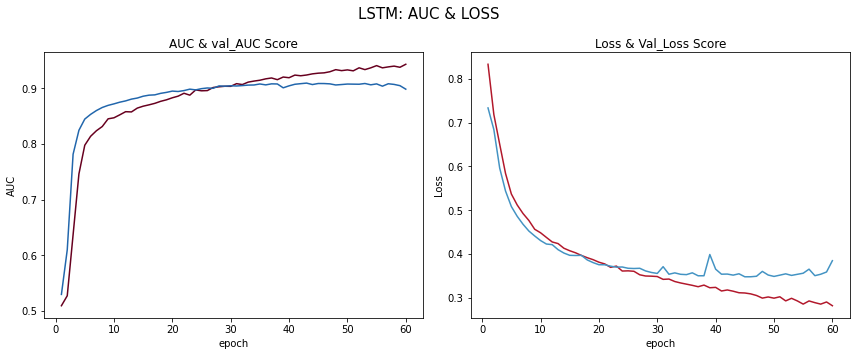

In [38]:
epoch = list(range(1,61))

color = ['#67001f','#b2182b','#4393c3','#2166ac']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

ax1.plot(epoch, history.history['auc'], color=color[0])
ax1.plot(epoch, history.history['val_auc'], color=color[3])
ax1.set_title('AUC & val_AUC Score')
ax1.set_ylabel("AUC")
ax1.set_xlabel("epoch")

ax2.plot(epoch, history.history['loss'], color=color[1])
ax2.plot(epoch, history.history['val_loss'], color=color[2])
ax2.set_title('Loss & Val_Loss Score')
ax2.set_ylabel("Loss")
ax2.set_xlabel("epoch")

fig.suptitle('LSTM: AUC & LOSS', fontsize=15)
plt.tight_layout()
plt.show()

### Comparação dos scores: LightGBM e LSTM

Acurácia, Precisão, Recall, F1

In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [40]:
def scores(model, X, y):
    
    predict_proba = model.predict(X, verbose=0)
    prediction_label = (model.predict(X) >= 0.5).astype("int32")  

    accuracy = accuracy_score(y, prediction_label)
    precision = precision_score(y, prediction_label)
    recall = recall_score(y, prediction_label)
    f1 = f1_score(y, prediction_label)

    return [accuracy, precision, recall, f1]

In [41]:
lgbm_score_list = scores(lgm_model, X_test_tfidf, y_test)

In [42]:
lstm_score_list = scores(model, test_X, y_test)

185/185 [==============================] - 1s 7ms/step


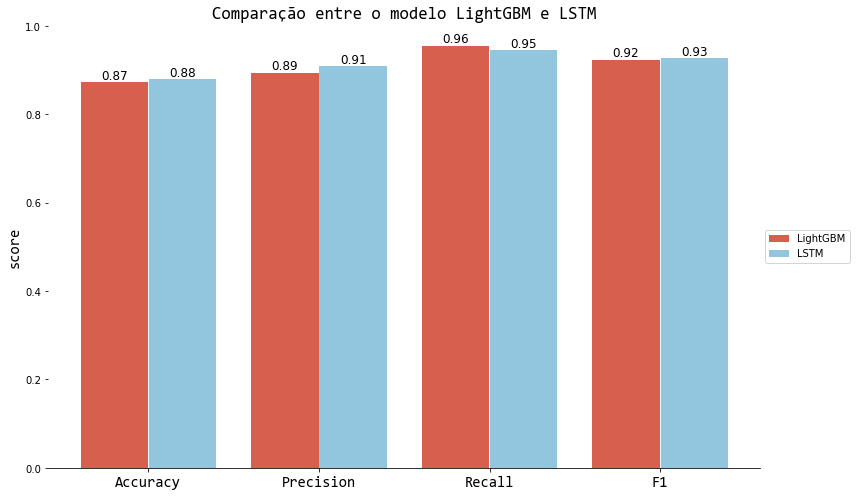

In [45]:
score_name = ['Accuracy', 'Precision', 'Recall', 'F1']

fig, ax = plt.subplots(figsize=(12,7))

x = np.arange(len(score_name))
width = 0.395

plt.bar(x-0.2, lgbm_score_list, width, label='LightGBM', color='#D6604D')
plt.bar(x+0.2, lstm_score_list, width, label='LSTM', color='#92C5DE')

plt.title('Comparação entre o modelo LightGBM e LSTM', {'fontname':"Consolas", 'fontsize': 17})
plt.ylabel("score", **csfont)
plt.xticks(x, score_name, **csfont)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

for bar in ax.patches:
    bar_value = bar.get_height()
    text = f'{round(bar_value,2):,}'
    text_x = bar.get_x() + bar.get_width() / 2
    text_y = bar.get_y() + bar_value
    ax.text(text_x, text_y, text, ha='center', va='bottom', size=12)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()
plt.show()